In [1]:
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import pickle

######################################################################

from lazypredict.Supervised import LazyRegressor

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuitCV, LassoCV, LarsCV, SGDRegressor, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

######################################################################

import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

######################################################################

pd.set_option('display.max_columns', 999)

import warnings
warnings.filterwarnings('ignore')

######################################################################

import sys
sys.path.insert(0, 'src/')
from modeling import *


In [2]:
df = pd.read_csv('cleaned_players_df.csv')
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,2020-21
0,P.K. Subban,Defenseman,1989,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160:14,1232:41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111:30,90.00,-21.00,18.00,1883.00,22:07,18:07,01:38,02:21,1427:51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163:07,1166:17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98:27,75.00,5.00,31.00,1731.00,22:39,18:30,01:33,02:35,1977:24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253:23,1507:00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217:01,90.00,18.00,59.00,2323.00,24:06,18:22,02:38,03:05,1610:40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172:00,1300:43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137:57,104.00,-8.00,40.00,1860.00,24:24,19:42,02:05,02:36,1792:38,45.00,6.00,75.00,176.00,68.00,102.00,2.00,24.00,313:51,1319:21,75.00,0.00,3.41,0.00,0.00,0.00,0.00,159:26,80.00,4.00,51.00,1922.00,26:21,19:24,02:20,04:36,2148:40,45.00,15.00,74.00,170.00,82.00,97.00,8.00,21.00,302:12,1669:11,74.00,0.00,8.8

In [3]:
df = df.rename(columns={ '2014-15': 'sal_14_15', '2015-16': 'sal_15_16',\
                         '2016-17': 'sal_16_17', '2017-18': 'sal_17_18',\
                         '2018-19': 'sal_18_19', '2019-20': 'sal_19_20',\
                        '2020-21':'sal_20_21'})
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,sal_20_21
0,P.K. Subban,Defenseman,1989,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160:14,1232:41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111:30,90.00,-21.00,18.00,1883.00,22:07,18:07,01:38,02:21,1427:51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163:07,1166:17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98:27,75.00,5.00,31.00,1731.00,22:39,18:30,01:33,02:35,1977:24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253:23,1507:00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217:01,90.00,18.00,59.00,2323.00,24:06,18:22,02:38,03:05,1610:40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172:00,1300:43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137:57,104.00,-8.00,40.00,1860.00,24:24,19:42,02:05,02:36,1792:38,45.00,6.00,75.00,176.00,68.00,102.00,2.00,24.00,313:51,1319:21,75.00,0.00,3.41,0.00,0.00,0.00,0.00,159:26,80.00,4.00,51.00,1922.00,26:21,19:24,02:20,04:36,2148:40,45.00,15.00,74.00,170.00,82.00,97.00,8.00,21.00,302:12,1669:11,74.00,0.00,8

In [4]:
df = df.fillna(0)

In [5]:
df = df[df['sal_20_21'] != 0]


### First Simple Model

In [6]:
formula = 'sal_20_21 ~ goals19'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     336.2
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.96e-57
Time:                        07:03:26   Log-Likelihood:                -7768.5
No. Observations:                 487   AIC:                         1.554e+04
Df Residuals:                     485   BIC:                         1.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.078e+06   1.31e+05      8.258      0.000    8.22e+05    1.33e+06
goals19     1.623e+05   8849.784     18.335      0.000    1.45e+05     1.8e+05
==============================================================================
Omnibus:                      138.143   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.360
Skew:                           1.363   Prob(JB):                     2.83e-85
Kurtosis:                       6.428   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
time_col = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce',\
            'timeOnIcePerGame', 'evenTimeOnIcePerGame','shortHandedTimeOnIce',\
           'powerPlayTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame']

years = ['14','15','16','17','18','19','20']

time_cols = []

for col in time_col:
    for year in years:
        time_cols.append(f'{col}{year}')

In [8]:
for col in time_cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.replace(':', '.'))
    df[col] = df[col].astype(float)

In [9]:
df['height'] = df['height'].map(lambda x: x.rstrip('"'))

In [10]:
df['height'] = [val.split("'") for val in df['height']]

In [11]:
df['height'] = [(float(val[0]) * 12) + float(val[1]) for val in df['height']]

In [12]:
df_cat_cols = ['name', 'birthCity', 'birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus', 'fullName']
df_no_cats = df.drop(df_cat_cols, axis=1)

In [13]:
multi_form = 'sal_20_21 ~' + '+'.join(df_no_cats.columns[:-1])
multiple_model = ols(multi_form, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     8.202
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           3.24e-57
Time:                        07:03:26   Log-Likelihood:                -7469.5
No. Observations:                 487   AIC:                         1.530e+04
Df Residuals:                     307   BIC:                         1.605e+04
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -3.74e+08   3.41e+08     -1.096      0.274   -1.05e+09    2.98e+08
birthDate                      1.864e+05   1.69e+05      1.103      0.271   -1.46e+05    5.19e+05
currentAge                     1.009e+05   1.71e+05      0.589      0.556   -2.36e+05    4.38e+05
height                         1.637e+04   5.59e+04      0.293      0.770   -9.36e+04    1.26e+05
weight                        -7012.4755   9112.882     -0.770      0.442   -2.49e+04    1.09e+04
timeOnIce20                    4.491e+05   3.89e+05      1.153      0.250   -3.17e+05    1.22e+06
assists20                     -3.439e+04   2.07e+04     -1.659      0.098   -7.52e+04    6394.975
goals20                        7.069e+04   2.85e+04      2.478      0.014    1.46e+04    1.27e+05
pim20                         -5742.0884   4064.563     -1.413      0.159   -1.37e+04    2255.838
shots20                        3141.4849   6230.976      0.504      0.615   -9119.339    1.54e+04
games20                       -3.713e+04    1.8e+04     -2.066      0.040   -7.25e+04   -1773.487
hits20                         -267.3052   4303.650     -0.062      0.951   -8735.690    8201.079
powerPlayGoals20              -8.287e+04   7.97e+04     -1.040      0.299    -2.4e+05    7.39e+04
powerPlayPoints20              4.138e+04    4.4e+04      0.941      0.347   -4.51e+04    1.28e+05
powerPlayTimeOnIce20          -4.517e+05   3.89e+05     -1.161      0.246   -1.22e+06    3.14e+05
evenTimeOnIce20               -4.481e+05   3.89e+05     -1.150      0.251   -1.21e+06    3.18e+05
penaltyMinutes20              -5742.0884   4064.563     -1.413      0.159   -1.37e+04    2255.838
faceOffPct20                     36.1586   5439.924      0.007      0.995   -1.07e+04    1.07e+04
shotPct20                      8100.6280   2.62e+04      0.309      0.758   -4.35e+04    5.97e+04
gameWinningGoals20            -1.243e+05   9.15e+04     -1.359      0.175   -3.04e+05    5.57e+04
overTimeGoals20               -3.249e+05   2.08e+05     -1.562      0.119   -7.34e+05    8.44e+04
shortHandedGoals20             1.326e+05   2.49e+05      0.533      0.595   -3.57e+05    6.22e+05
shortHandedPoints20            1.818e+05   1.86e+05      0.975      0.330   -1.85e+05    5.49e+05
shortHandedTimeOnIce20        -4.506e+05   3.89e+05     -1.159      0.247   -1.22e+06    3.15e+05
blocked20                      1.156e+04   8394.416      1.377      0.169   -4957.557    2.81e+04
plusMinus20                   -2.033e+04   1.04e+04     -1.947      0.052   -4.09e+04     219.531
points20                        3.63e+04   1.66e+04      2.183      0.030    3580.367     6.9e+04
shifts20                        357.9336   1721.342      0.208      0.835   -3029.188    3745.055
timeOnIcePerGame20            -4.102e+05   4.

In [14]:
less_than_05 = df_no_cats[['sal_20_21', 'games20', 'gameWinningGoals20', 'overTimeGoals20', 'timeOnIcePerGame18', 'evenTimeOnIcePerGame18', 'powerPlayTimeOnIce18', 'assists17', 'goals17',\
           'pim17', 'powerPlayGoals17', 'penaltyMinutes17', 'shortHandedGoals17', 'powerPlayGoals16', 'blocked17', 'goals15']]

# multi_form = 'sal_20_21 ~' + '+'.join(less_than_05.columns[1:])
# multiple_model = ols(multi_form, less_than_05).fit()
# multiple_model_summary = multiple_model.summary()
# multiple_model_summary

In [15]:
df_corr=less_than_05.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr

,cc
pairs,
"(timeOnIcePerGame18, evenTimeOnIcePerGame18)",0.99
"(goals17, powerPlayGoals17)",0.84
"(assists17, goals17)",0.80
"(goals15, powerPlayGoals16)",0.76
"(powerPlayTimeOnIce18, assists17)",0.75
...,...
"(shortHandedGoals17, gameWinningGoals20)",0.14
"(pim17, overTimeGoals20)",0.12
"(shortHandedGoals17, overTimeGoals20)",0.12


In [16]:
less_than_05 = less_than_05.drop(['timeOnIcePerGame18', 'powerPlayGoals17', 'goals17', 'goals15'], axis=1)

In [17]:
multi_form = 'sal_20_21 ~' + '+'.join(less_than_05.columns[1:])
multiple_model = ols(multi_form, less_than_05).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     64.09
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.08e-81
Time:                        07:03:26   Log-Likelihood:                -7689.1
No. Observations:                 487   AIC:                         1.540e+04
Df Residuals:                     476   BIC:                         1.545e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.249e+05   2.04e+05      1.589      0.113   -7.68e+04    7.27e+05
games20                 2437.7668   4400.734      0.554      0.580   -6209.500    1.11e+04
gameWinningGoals20      2.894e+05   6.53e+04      4.430      0.000    1.61e+05    4.18e+05
overTimeGoals20         1.001e+05   1.89e+05      0.529      0.597   -2.72e+05    4.72e+05
evenTimeOnIcePerGame18  4.743e+04   2.05e+04      2.318      0.021    7222.741    8.76e+04
powerPlayTimeOnIce18    9682.0682   1516.377      6.385      0.000    6702.447    1.27e+04
assists17               5.879e+04   1.09e+04      5.372      0.000    3.73e+04    8.03e+04
pim17                  -3994.7746   2326.858     -1.717      0.087   -8566.958     577.409
penaltyMinutes17       -3994.7746   2326.858     -1.717      0.087   -8566.958     577.409
shortHandedGoals17     -8.501e+04    1.4e+05     -0.608      0.543    -3.6e+05     1.9e+05
powerPlayGoals16       -5.859e+04    4.1e+04     -1.428      0.154   -1.39e+05     2.2e+04
blocked17               2342.9524   2650.469      0.884      0.377   -2865.114    7551.018
==============================================================================
Omnibus:                      176.282   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.856
Skew:                           1.455   Prob(JB):                    3.17e-225
Kurtosis:                       9.518   Cond. No.                     5.51e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
# high_colin_list = []

# high_colin_cols = ['evenTimeOnIce', 'shifts', 'evenTimeOnIcePerGame']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [19]:
# df_corr=df_no_cats.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
# df_corr.set_index(['pairs'], inplace = True)
# df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
# df_corr.columns = ['cc']
# df_corr.drop_duplicates(inplace=True)
# df_corr = df_corr[df_corr['cc'] < 1.0000]
# df_corr.head(50)

In [20]:
# high_colin_list = []

# high_colin_cols = ['assists', 'shortHandedTimeOnIce', 'shortHandedTimeOnIcePerGame',\
#                   'powerPlayTimeOnIcePerGame']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [21]:
# df_no_cats.drop('birthDate', axis=1, inplace=True)

In [22]:
# high_colin_list = []

# high_colin_cols = ['timeOnIce', 'shots', 'points']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [23]:
# df_corr=df_no_cats.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
# df_corr.set_index(['pairs'], inplace = True)
# df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
# df_corr.columns = ['cc']
# df_corr.drop_duplicates(inplace=True)
# df_corr = df_corr[df_corr['cc'] < 1.0000]
# df_corr.head(25)

In [24]:
less_than_05

,sal_20_21,games20,gameWinningGoals20,overTimeGoals20,evenTimeOnIcePerGame18,powerPlayTimeOnIce18,assists17,pim17,penaltyMinutes17,shortHandedGoals17,powerPlayGoals16,blocked17
0,8000000.00,68.00,3.00,0.00,18.22,253.23,30.00,44.00,44.00,0.00,2.00,104.00
1,4700000.00,27.00,0.00,0.00,16.08,12.06,9.00,24.00,24.00,0.00,1.00,96.00
2,4675000.00,69.00,2.00,0.00,17.39,124.24,28.00,58.00,58.00,0.00,0.00,73.00
3,1500000.00,29.00,1.00,0.00,14.47,14.15,6.00,51.00,51.00,0.00,0.00,79.00
4,3600000.00,56.00,1.00,0.00,13.22,214.24,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
482,700000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
483,750000.00,28.00,1.00,0.00,10.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00
484,874125.00,0.00,0.00,0.00,11.52,133.19,0.00,0.00,0.00,0.00,0.00,0.00
485,874125.00,0.00,0.00,0.00,11.52,133.19,0.00,0.00,0.00,0.00,0.00,0.00


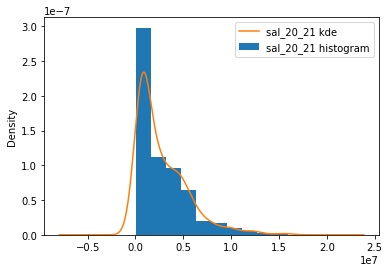

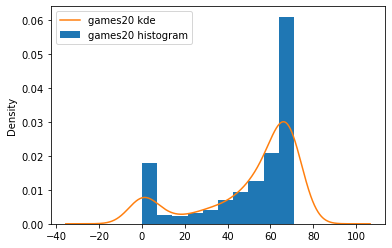

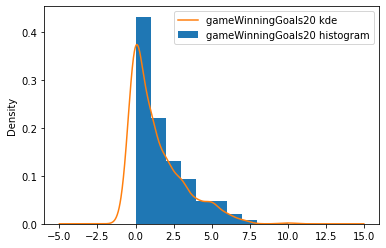

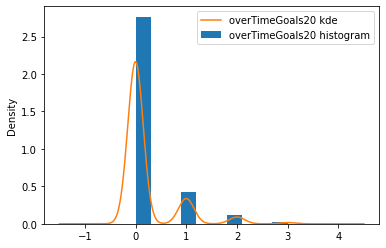

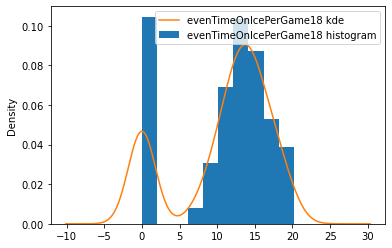

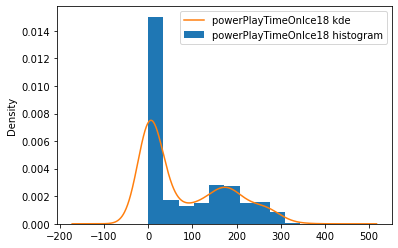

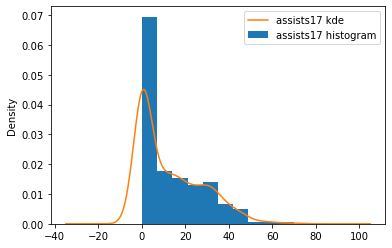

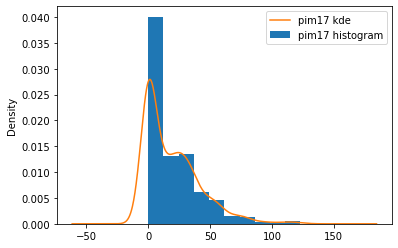

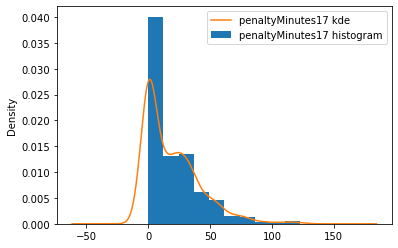

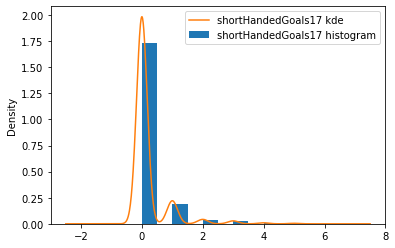

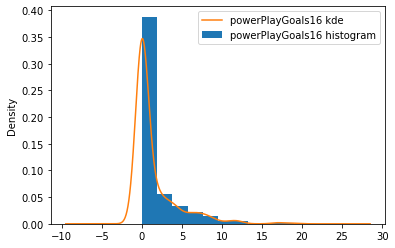

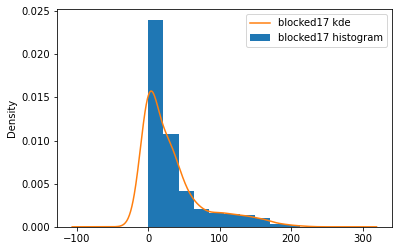

In [25]:
for column in less_than_05:
    less_than_05[column].plot.hist(density=True, label = column+' histogram')
    less_than_05[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

In [26]:
less_than_05.columns.tolist()

['sal_20_21',
 'games20',
 'gameWinningGoals20',
 'overTimeGoals20',
 'evenTimeOnIcePerGame18',
 'powerPlayTimeOnIce18',
 'assists17',
 'pim17',
 'penaltyMinutes17',
 'shortHandedGoals17',
 'powerPlayGoals16',
 'blocked17']

In [27]:
X = less_than_05.drop('sal_20_21', axis=1)
y = less_than_05['sal_20_21']

numeric_features = [ 'games20',
 'gameWinningGoals20',
 'overTimeGoals20',
 'evenTimeOnIcePerGame18',
 'powerPlayTimeOnIce18',
 'assists17',
 'pim17',
 'penaltyMinutes17',
 'shortHandedGoals17',
 'powerPlayGoals16',
 'blocked17']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# categorical_features = ['embarked', 'sex', 'pclass']
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
#         ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.443


In [28]:
df[df_cat_cols] = df[df_cat_cols].astype(str)

less_than_05_w_cats = pd.concat([less_than_05, df[df_cat_cols]], axis=1)

less_than_05_w_cats = less_than_05_w_cats.drop(['fullName', 'birthCity'], axis=1)

less_than_05_w_cats

,sal_20_21,games20,gameWinningGoals20,overTimeGoals20,evenTimeOnIcePerGame18,powerPlayTimeOnIce18,assists17,pim17,penaltyMinutes17,shortHandedGoals17,powerPlayGoals16,blocked17,name,birthStateProvince,birthCountry,alternateCaptain,captain,rookie,shootsCatches,rosterStatus
0,8000000.00,68.00,3.00,0.00,18.22,253.23,30.00,44.00,44.00,0.00,2.00,104.00,Defenseman,ON,CAN,True,False,False,R,Y
1,4700000.00,27.00,0.00,0.00,16.08,12.06,9.00,24.00,24.00,0.00,1.00,96.00,Defenseman,SK,CAN,False,False,False,L,Y
2,4675000.00,69.00,2.00,0.00,17.39,124.24,28.00,58.00,58.00,0.00,0.00,73.00,Defenseman,SK,CAN,True,False,False,R,Y
3,1500000.00,29.00,1.00,0.00,14.47,14.15,6.00,51.00,51.00,0.00,0.00,79.00,Defenseman,IL,USA,False,False,False,R,Y
4,3600000.00,56.00,1.00,0.00,13.22,214.24,0.00,0.00,0.00,0.00,0.00,0.00,Defenseman,WI,USA,False,False,False,L,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,700000.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Right Wing,MB,CAN,False,False,True,R,Y
483,750000.00,28.00,1.00,0.00,10.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Center,QC,CAN,False,False,False,R,Y
484,874125.00,0.00,0.00,0.00,11.52,133.19,0.00,0.00,0.00,0.00,0.00,0.00,Center,MB,CAN,False,False,False,R,Y
485,874125.00,0.00,0.00,0.00,11.52,133.19,0.00,0.00,0.00,0.00,0.00,0.00,Center,MB,CAN,False,False,False,R,Y


In [29]:
less_than_05_w_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 486
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sal_20_21               487 non-null    float64
 1   games20                 487 non-null    float64
 2   gameWinningGoals20      487 non-null    float64
 3   overTimeGoals20         487 non-null    float64
 4   evenTimeOnIcePerGame18  487 non-null    float64
 5   powerPlayTimeOnIce18    487 non-null    float64
 6   assists17               487 non-null    float64
 7   pim17                   487 non-null    float64
 8   penaltyMinutes17        487 non-null    float64
 9   shortHandedGoals17      487 non-null    float64
 10  powerPlayGoals16        487 non-null    float64
 11  blocked17               487 non-null    float64
 12  name                    487 non-null    object 
 13  birthStateProvince      487 non-null    object 
 14  birthCountry            487 non-null    ob

In [30]:
X = less_than_05_w_cats.drop('sal_20_21', axis=1)
y = less_than_05_w_cats['sal_20_21']

numeric_features = [ 'games20',
 'gameWinningGoals20',
 'overTimeGoals20',
 'evenTimeOnIcePerGame18',
 'powerPlayTimeOnIce18',
 'assists17',
 'pim17',
 'penaltyMinutes17',
 'shortHandedGoals17',
 'powerPlayGoals16',
 'blocked17']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.539


# Summing redundant columns

In [31]:
redundant = ['timeOnIce',
 'assists',
 'goals',
 'pim',
 'shots',
 'games',
 'hits',
 'powerPlayGoals',
 'powerPlayPoints',
 'powerPlayTimeOnIce',
 'evenTimeOnIce',
 'penaltyMinutes',
 'faceOffPct',
 'shotPct',
 'gameWinningGoals',
 'overTimeGoals',
 'shortHandedGoals',
 'shortHandedPoints',
 'shortHandedTimeOnIce',
 'blocked',
 'plusMinus',
 'points',
 'shifts',
 'timeOnIcePerGame',
 'evenTimeOnIcePerGame',
 'shortHandedTimeOnIcePerGame',
 'powerPlayTimeOnIcePerGame']

redundant_cols = []

for year in years:
    for col in redundant:
        redundant_cols.append(f'{col}{year}')

In [32]:
redundant_dict = {}

for num in range(0, 27):
    redundant_dict[num] = {}
    for i in range(num, len(redundant_cols), 27):
        redundant_dict[num][i] = redundant_cols[i]

In [33]:
for num in range(0,27):
    val = redundant_dict[num].values()
    cum_stats = np.sum(df_no_cats[val],axis=1)
    df_no_cats[num] = pd.DataFrame(cum_stats)

In [34]:
df_no_cats.rename(columns={0:'total_timeOnIce',
 1:'total_assists',
 2:'total_goals',
 3:'total_pim',
 4:'total_shots',
 5:'total_games',
 6:'total_hits',
 7:'total_powerPlayGoals',
 8:'total_powerPlayPoints',
 9:'total_powerPlayTimeOnIce',
 10:'total_evenTimeOnIce',
 11:'total_penaltyMinutes',
 12:'total_faceOffPct',
 13:'total_shotPct',
 14:'total_gameWinningGoals',
 15:'total_overTimeGoals',
 16:'total_shortHandedGoals',
 17:'total_shortHandedPoints',
 18:'total_shortHandedTimeOnIce',
 19:'total_blocked',
 20:'total_plusMinus',
 21:'total_points',
 22:'total_shifts',
 23:'total_timeOnIcePerGame',
 24:'total_evenTimeOnIcePerGame',
 25:'total_shortHandedTimeOnIcePerGame',
 26:'total_powerPlayTimeOnIcePerGame'}, inplace=True)

In [35]:
cum_df = df_no_cats.drop(redundant_cols, axis=1)
cum_df.to_csv('cumulative_df.csv')

In [36]:
cum_df = cum_df[['sal_20_21',
                 'currentAge',
                 'height',
                 'weight',
                 'total_timeOnIce',
                 'total_assists',
                 'total_goals',
                 'total_pim',
                 'total_shots',
                 'total_games',
                 'total_hits',
                 'total_powerPlayGoals',
                 'total_powerPlayPoints',
                 'total_powerPlayTimeOnIce',
                 'total_evenTimeOnIce',
                 'total_penaltyMinutes',
                 'total_faceOffPct',
                 'total_shotPct',
                 'total_gameWinningGoals',
                 'total_overTimeGoals',
                 'total_shortHandedGoals',
                 'total_shortHandedPoints',
                 'total_shortHandedTimeOnIce',
                 'total_blocked',
                 'total_plusMinus',
                 'total_points',
                 'total_shifts',
                 'total_timeOnIcePerGame',
                 'total_evenTimeOnIcePerGame',
                 'total_shortHandedTimeOnIcePerGame',
                 'total_powerPlayTimeOnIcePerGame']]

In [37]:
multi_form = 'sal_20_21 ~' + '+'.join(cum_df.columns[1:])
multiple_model = ols(multi_form, cum_df).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     30.78
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           2.49e-87
Time:                        07:03:29   Log-Likelihood:                -7639.0
No. Observations:                 487   AIC:                         1.534e+04
Df Residuals:                     458   BIC:                         1.546e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          4.601e+06   3.06e+06      1.504      0.133   -1.41e+06    1.06e+07
currentAge                         -2.12e+05   2.99e+04     -7.087      0.000   -2.71e+05   -1.53e+05
height                             3.011e+04   5.27e+04      0.571      0.568   -7.34e+04    1.34e+05
weight                            -4186.8734   8507.694     -0.492      0.623   -2.09e+04    1.25e+04
total_timeOnIce                    6102.5834   1.46e+05      0.042      0.967   -2.82e+05    2.94e+05
total_assists                     -1.278e+04   6096.670     -2.097      0.037   -2.48e+04    -802.136
total_goals                        3.129e+04   8076.597      3.874      0.000    1.54e+04    4.72e+04
total_pim                         -1099.4010    560.491     -1.961      0.050   -2200.854       2.052
total_shots                        -954.4804    870.990     -1.096      0.274   -2666.112     757.151
total_games                       -9973.0929   4049.421     -2.463      0.014   -1.79e+04   -2015.345
total_hits                          791.1200    484.645      1.632      0.103    -161.283    1743.523
total_powerPlayGoals              -5.377e+04   2.37e+04     -2.273      0.024      -1e+05   -7275.643
total_powerPlayPoints              2.849e+04    1.2e+04      2.368      0.018    4844.399    5.21e+04
total_powerPlayTimeOnIce          -7919.5976   1.47e+05     -0.054      0.957   -2.96e+05     2.8e+05
total_evenTimeOnIce               -4947.5202   1.46e+05     -0.034      0.973   -2.93e+05    2.83e+05
total_penaltyMinutes              -1099.4010    560.491     -1.961      0.050   -2200.854       2.052
total_faceOffPct                   1326.6362   1435.110      0.924      0.356   -1493.579    4146.852
total_shotPct                     -1327.6661   6620.097     -0.201      0.841   -1.43e+04    1.17e+04
total_gameWinningGoals            -4.248e+04   3.17e+04     -1.341      0.181   -1.05e+05    1.98e+04
total_overTimeGoals               -8.436e+04   6.38e+04     -1.323      0.187    -2.1e+05     4.1e+04
total_shortHandedGoals            -7.458e+04   8.87e+04     -0.840      0.401   -2.49e+05    9.98e+04
total_shortHandedPoints            6.179e+04   6.04e+04      1.023      0.307   -5.69e+04     1.8e+05
total_shortHandedTimeOnIce        -5870.5594   1.46e+05     -0.040      0.968   -2.94e+05    2.82e+05
total_blocked                      1409.0528   1062.358      1.326      0.185    -678.647    3496.753
total_plusMinus                    5568.0223   3040.239      1.831      0.068    -406.525    1.15e+04
total_points                        1.85e+04   3681.111      5.026      0.000    1.13e+04    2.57e+04
total_shifts                       -337.2134    255.953     -1.317      0.188    -840.201     165.774
total_timeOnIcePerGame 

In [38]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(25)

,cc
pairs,
"(total_evenTimeOnIce, total_timeOnIce)",1.00
"(total_timeOnIcePerGame, total_evenTimeOnIcePerGame)",1.00
"(total_shifts, total_timeOnIce)",0.99
"(total_shifts, total_evenTimeOnIce)",0.99
"(total_powerPlayTimeOnIce, total_powerPlayTimeOnIcePerGame)",0.99
"(total_shortHandedTimeOnIce, total_shortHandedTimeOnIcePerGame)",0.98
"(total_shifts, total_games)",0.98
"(total_assists, total_points)",0.97
"(total_evenTimeOnIce, total_timeOnIcePerGame)",0.97


In [39]:
cum_df.drop('total_evenTimeOnIce', axis=1, inplace=True)

cum_df.drop(['total_evenTimeOnIcePerGame', 'total_shifts', 'total_powerPlayTimeOnIcePerGame',\
            'total_shortHandedTimeOnIcePerGame'], axis=1, inplace = True)

cum_df.drop(['total_points', 'total_powerPlayTimeOnIce', 'total_gameWinningGoals', 'total_timeOnIcePerGame'], axis=1, inplace=True)

cum_df.drop(['total_games', 'total_powerPlayPoints', 'total_powerPlayGoals',\
             'total_shortHandedPoints', 'total_shots'], axis=1, inplace=True)

In [40]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head()

,cc
pairs,
"(total_timeOnIce, total_assists)",0.87
"(total_goals, total_assists)",0.84
"(total_goals, total_shotPct)",0.83
"(total_shortHandedTimeOnIce, total_blocked)",0.82
"(total_faceOffPct, total_shotPct)",0.79


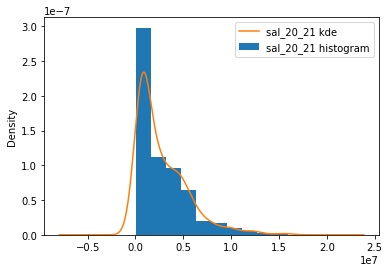

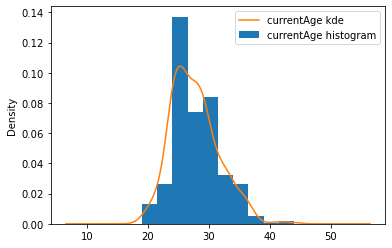

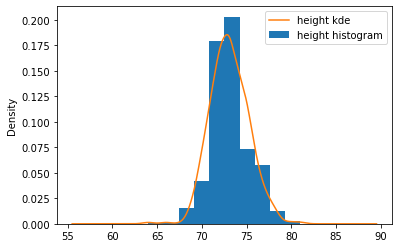

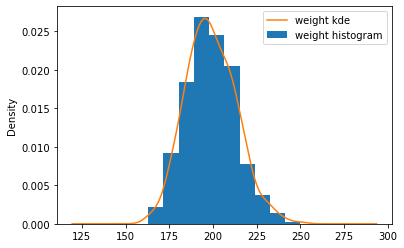

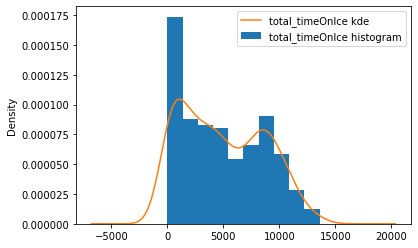

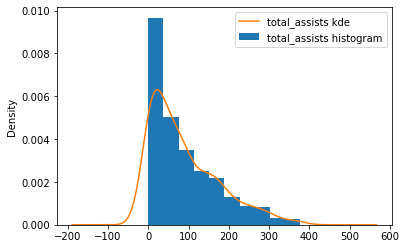

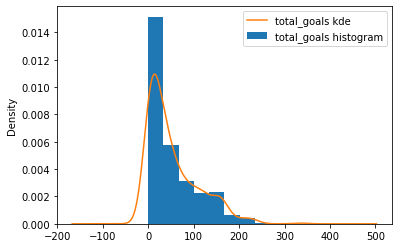

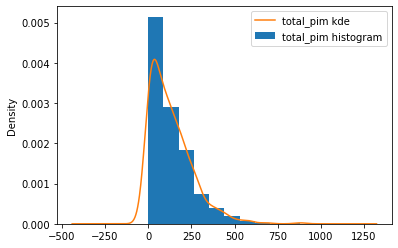

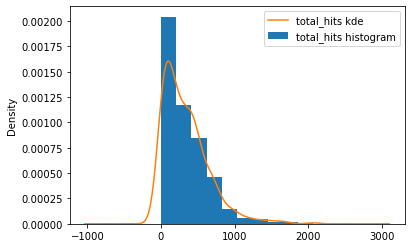

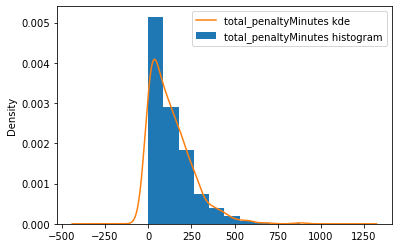

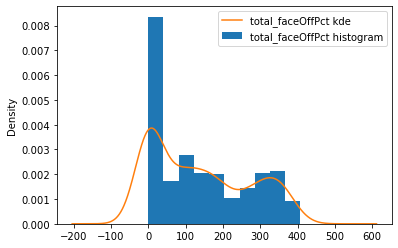

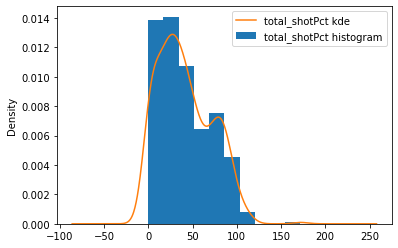

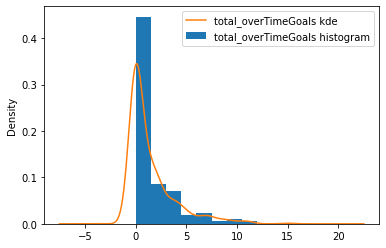

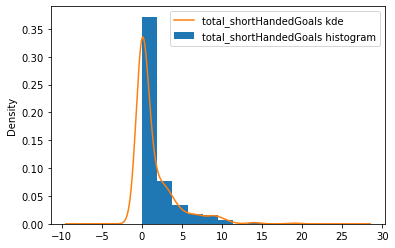

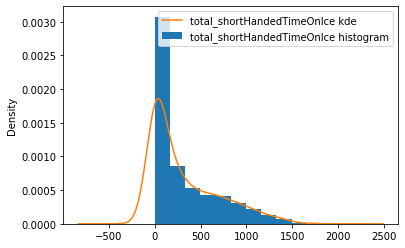

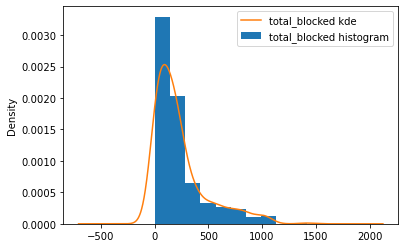

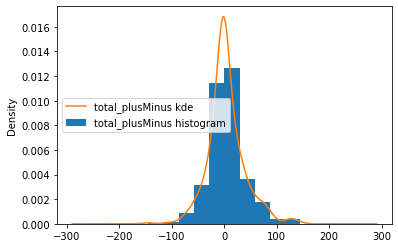

In [41]:
for column in cum_df:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    df_no_cats[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

# Above we can see that the data is not normally distributed. We will have to use a transformer below in our pipeline

In [42]:
pf = PolynomialFeatures(degree=2)

X = cum_df

pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
x = corr_df[corr_df['x0'] > .70]['x0'].sort_values(ascending=False)
x.head(50)

x0       1.00
x0 x2    1.00
x0 x3    0.99
x0 x1    0.98
x0^2     0.92
x0 x4    0.91
x0 x5    0.88
x0 x11   0.88
x0 x6    0.84
x0 x9    0.76
x0 x7    0.76
x0 x10   0.76
x0 x12   0.74
x2 x5    0.72
x5       0.72
x3 x5    0.72
Name: x0, dtype: float64

In [43]:
cum_df.head()

,sal_20_21,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_hits,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_overTimeGoals,total_shortHandedGoals,total_shortHandedTimeOnIce,total_blocked,total_plusMinus
0,8000000.00,32,72.00,210,12478.50,239.00,73.00,495.00,667.00,495.00,33.33,41.86,2.00,1.00,955.60,706.00,15.00
1,4700000.00,27,73.00,206,7060.60,95.00,15.00,104.00,175.00,104.00,0.00,37.89,0.00,0.00,708.13,593.00,13.00
2,4675000.00,26,74.00,205,8942.67,126.00,37.00,264.00,435.00,264.00,0.00,30.81,0.00,0.00,419.79,394.00,-107.00
3,1500000.00,27,71.00,192,3632.25,35.00,12.00,152.00,223.00,152.00,0.00,31.65,0.00,0.00,94.19,283.00,-20.00
4,3600000.00,26,70.00,190,3807.59,82.00,13.00,32.00,90.00,32.00,0.00,15.88,0.00,0.00,26.45,211.00,-24.00


In [44]:
cum_df['assist_height'] = cum_df['height'] * cum_df['total_assists']

In [45]:
X = cum_df.drop('sal_20_21', axis=1)
y = cum_df['sal_20_21']

numeric_features = [
 'currentAge',
 'height',
 'weight',
 'total_timeOnIce',
 'total_assists',
 'total_goals',
 'total_pim',
 'total_hits',
 'total_penaltyMinutes',
 'total_faceOffPct',
 'total_shotPct',
 'total_overTimeGoals',
 'total_shortHandedGoals',
 'total_shortHandedTimeOnIce',
 'total_blocked',
 'total_plusMinus',
 'assist_height']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.622


In [46]:
cum_df_w_cats = pd.concat([cum_df, df[df_cat_cols]], axis=1)
cum_df_w_cats = cum_df_w_cats.drop(['fullName', 'birthCity'], axis=1)
cum_df_w_cats

,sal_20_21,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_hits,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_overTimeGoals,total_shortHandedGoals,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,assist_height,name,birthStateProvince,birthCountry,alternateCaptain,captain,rookie,shootsCatches,rosterStatus
0,8000000.00,32,72.00,210,12478.50,239.00,73.00,495.00,667.00,495.00,33.33,41.86,2.00,1.00,955.60,706.00,15.00,17208.00,Defenseman,ON,CAN,True,False,False,R,Y
1,4700000.00,27,73.00,206,7060.60,95.00,15.00,104.00,175.00,104.00,0.00,37.89,0.00,0.00,708.13,593.00,13.00,6935.00,Defenseman,SK,CAN,False,False,False,L,Y
2,4675000.00,26,74.00,205,8942.67,126.00,37.00,264.00,435.00,264.00,0.00,30.81,0.00,0.00,419.79,394.00,-107.00,9324.00,Defenseman,SK,CAN,True,False,False,R,Y
3,1500000.00,27,71.00,192,3632.25,35.00,12.00,152.00,223.00,152.00,0.00,31.65,0.00,0.00,94.19,283.00,-20.00,2485.00,Defenseman,IL,USA,False,False,False,R,Y
4,3600000.00,26,70.00,190,3807.59,82.00,13.00,32.00,90.00,32.00,0.00,15.88,0.00,0.00,26.45,211.00,-24.00,5740.00,Defenseman,WI,USA,False,False,False,L,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,700000.00,24,74.00,217,12.06,0.00,0.00,0.00,2.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Right Wing,MB,CAN,False,False,True,R,Y
483,750000.00,24,76.00,205,371.89,5.00,5.00,10.00,48.00,10.00,162.02,11.90,0.00,0.00,15.45,8.00,2.00,380.00,Center,QC,CAN,False,False,False,R,Y
484,874125.00,22,74.00,198,2087.12,35.00,26.00,57.00,120.00,57.00,101.82,21.54,1.00,0.00,3.57,45.00,-7.00,2590.00,Center,MB,CAN,False,False,False,R,Y
485,874125.00,22,74.00,198,2087.12,35.00,26.00,57.00,120.00,57.00,101.82,21.54,1.00,0.00,3.57,45.00,-7.00,2590.00,Center,MB,CAN,False,False,False,R,Y


In [47]:
X = cum_df_w_cats.drop('sal_20_21', axis=1)
y = cum_df_w_cats['sal_20_21']

numeric_features = [
 'currentAge',
 'height',
 'weight',
 'total_timeOnIce',
 'total_assists',
 'total_goals',
 'total_pim',
 'total_hits',
 'total_penaltyMinutes',
 'total_faceOffPct',
 'total_shotPct',
 'total_overTimeGoals',
 'total_shortHandedGoals',
 'total_shortHandedTimeOnIce',
 'total_blocked',
 'total_plusMinus',
 'assist_height']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.622


In [48]:
cum_df_w_cats.to_csv('cum_df_w_cats.csv')

In [49]:
# ohe = OneHotEncoder(drop='first', sparse=False)
# cum_df_full_cats = cum_df_full.select_dtypes(['object', 'bool'])
# cats_xfmr = ohe.fit_transform(cum_df_full_cats)
# ohe_df = pd.DataFrame(cats_xfmr, columns=ohe.get_feature_names())

In [50]:
# cum_df_full_int = cum_df_full.select_dtypes(['int64', 'float64'])
# ohe_full = pd.concat([cum_df_full_int, ohe_df], axis=1)
# ohe_full.to_csv('ohe_df.csv')
# ohe_full.head()

# Train Test Split

In [51]:
ohe_full = pd.read_csv('ohe_df.csv')
ohe_full.head()

,Unnamed: 0,Unnamed: 0.1,sal_20_21,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_hits,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_overTimeGoals,total_shortHandedGoals,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,assist_height,x0_Defenseman,x0_Left Wing,x0_Right Wing,x1_AB,x1_AK,x1_AL,x1_AZ,x1_BC,x1_CA,x1_CO,x1_CT,x1_FL,x1_IL,x1_MA,x1_MB,x1_MD,x1_ME,x1_MI,x1_MN,x1_MO,x1_NB,x1_NE,x1_NJ,x1_NL,x1_NS,x1_NY,x1_OH,x1_OK,x1_ON,x1_OR,x1_PA,x1_PE,x1_QC,x1_RI,x1_SC,x1_SK,x1_TX,x1_UT,x1_WA,x1_WI,x2_CAN,x2_CHE,x2_CZE,x2_DEU,x2_DNK,x2_FIN,x2_FRA,x2_LVA,x2_NLD,x2_RUS,x2_SVK,x2_SVN,x2_SWE,x2_USA,x3_True,x4_True,x5_True,x6_R,x7_Y
0,0,0,8000000.00,32,72.00,210,12478.50,239.00,73.00,495.00,667.00,495.00,33.33,41.86,2.00,1.00,955.60,706.00,15.00,17208.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
1,1,1,4700000.00,27,73.00,206,7060.60,95.00,15.00,104.00,175.00,104.00,0.00,37.89,0.00,0.00,708.13,593.00,13.00,6935.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,2,2,4675000.00,26,74.00,205,8942.67,126.00,37.00,264.00,435.00,264.00,0.00,30.81,0.00,0.00,419.79,394.00,-107.00,9324.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00
3,3,3,1500000.00,27,71.00,192,3632.25,35.00,12.00,152.00,223.00,152.00,0.00,31.65,0.00,0.00,94.19,283.00,-20.00,2485.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
4,4,4,3600000.00,26,70.00,190,3807.59,82.00,13.00,32.00,90.00,32.00,0.00,15.88,0.00,0.00,26.45,211.00,-24.00,5740.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [52]:
cum_df_full_no_ohe = pd.read_csv('cum_df_w_cats.csv')
cum_df_full_no_ohe.head()

,Unnamed: 0,sal_20_21,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_hits,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_overTimeGoals,total_shortHandedGoals,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,assist_height,name,birthStateProvince,birthCountry,alternateCaptain,captain,rookie,shootsCatches,rosterStatus
0,0,8000000.00,32,72.00,210,12478.50,239.00,73.00,495.00,667.00,495.00,33.33,41.86,2.00,1.00,955.60,706.00,15.00,17208.00,Defenseman,ON,CAN,True,False,False,R,Y
1,1,4700000.00,27,73.00,206,7060.60,95.00,15.00,104.00,175.00,104.00,0.00,37.89,0.00,0.00,708.13,593.00,13.00,6935.00,Defenseman,SK,CAN,False,False,False,L,Y
2,2,4675000.00,26,74.00,205,8942.67,126.00,37.00,264.00,435.00,264.00,0.00,30.81,0.00,0.00,419.79,394.00,-107.00,9324.00,Defenseman,SK,CAN,True,False,False,R,Y
3,3,1500000.00,27,71.00,192,3632.25,35.00,12.00,152.00,223.00,152.00,0.00,31.65,0.00,0.00,94.19,283.00,-20.00,2485.00,Defenseman,IL,USA,False,False,False,R,Y
4,4,3600000.00,26,70.00,190,3807.59,82.00,13.00,32.00,90.00,32.00,0.00,15.88,0.00,0.00,26.45,211.00,-24.00,5740.00,Defenseman,WI,USA,False,False,False,L,Y


In [53]:
X = cum_df_full_no_ohe.drop(['sal_20_21', 'Unnamed: 0'], axis=1)
y = cum_df_full_no_ohe['sal_20_21']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

# Linear Regression

# Lazy Regressor

In [55]:
X1 = ohe_full.drop(['sal_20_21', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
y1 = ohe_full['sal_20_21']

X_tr, X_te, y_tr, y_te = train_test_split(X1, y1, random_state=42)

In [56]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_tr, X_te, y_tr, y_te)

models

100%|██████████| 41/41 [00:03<00:00, 12.22it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
OrthogonalMatchingPursuitCV,-0.33,0.50,1804870.00,0.01
ExtraTreesRegressor,-0.35,0.50,1817716.25,0.31
OrthogonalMatchingPursuit,-0.36,0.50,1819278.86,0.01
LassoCV,-0.39,0.48,1843862.48,0.18
LassoLarsCV,-0.40,0.48,1850768.77,0.10
LarsCV,-0.41,0.48,1853305.45,0.11
SGDRegressor,-0.44,0.46,1877512.83,0.02
RidgeCV,-0.46,0.46,1886415.08,0.02
RandomForestRegressor,-0.46,0.46,1887483.68,0.39


### ExtraTreesRegressor

In [57]:
categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor(random_state=42))])

param_grid={
        'classifier__n_estimators': range(50,375,25),
        'classifier__max_features': range(0,40,5),
        'classifier__min_samples_leaf': range(0,50,5),
        'classifier__min_samples_split': range(0,50,5),
        'classifier__n_jobs': [-1]
    },
    

gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='r2')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print("RMSE train: {}".format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)


RMSE train: 2082914.0749393336
RMSE test: 2251989.183671501
{'classifier__max_features': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 45, 'classifier__n_estimators': 200, 'classifier__n_jobs': -1}


In [61]:
categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor(random_state=42))])

param_grid={
        'classifier__n_estimators': range(50,375,25),
        'classifier__max_features': range(0,40,5),
        'classifier__min_samples_leaf': range(0,50,5),
        'classifier__min_samples_split': range(0,50,5),
        'classifier__n_jobs': [-1]
    },
    

gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print("RMSE train: {}".format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

RMSE train: 2079469.5869182418
RMSE test: 2251688.4464691714
{'classifier__max_features': 15, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 45, 'classifier__n_estimators': 50, 'classifier__n_jobs': -1}


### OrthogonalMatchingPursuitCV

In [62]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', OrthogonalMatchingPursuitCV())])

param_grid = {
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': range(0,15)
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

RMSE train: 1558980.1128377032
RMSE test: 1892553.8968696606
{'classifier__fit_intercept': False, 'classifier__max_iter': 10}


### LassoCV

In [63]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LassoCV(random_state=42))])

param_grid = {
    'classifier__n_alphas': range(50,1000,50),
    'classifier__max_iter': range(50,1000,50),
    'classifier__verbose': [True, False], 
    'classifier__positive': [True,False],
    'classifier__selection': ['random', 'cyclic'],
    'classifier__n_jobs': [-1]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

RMSE train: 1416423.260824026
RMSE test: 1848747.522315936
{'classifier__max_iter': 100, 'classifier__n_alphas': 800, 'classifier__n_jobs': -1, 'classifier__positive': False, 'classifier__selection': 'random', 'classifier__verbose': True}


..............................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


### LarsCV

In [64]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LarsCV())])

param_grid = {
    'classifier__max_n_alphas': range(500,2000,100),
    'classifier__max_iter': range(50,1000,50),
    'classifier__verbose': [True, False], 
    'classifier__normalize': [True, False]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

RMSE train: 1703110.925113955
RMSE test: 2055148.2135267386
{'classifier__max_iter': 100, 'classifier__max_n_alphas': 500, 'classifier__normalize': False, 'classifier__verbose': True}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


### SGDRegressor

In [66]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDRegressor())])

param_grid = {
    'classifier__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__l1_ratio': [0,1],
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': range(50,2000,100),
    'classifier__shuffle': [True, False],
    'classifier__random_state': [42],
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [.0001, .001, .01, .03, .1, .3, 1, 3]
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

RMSE train: 1417798.6504478892
RMSE test: 1860236.1165808917
{'classifier__eta0': 0.001, 'classifier__fit_intercept': True, 'classifier__l1_ratio': 0, 'classifier__learning_rate': 'constant', 'classifier__loss': 'squared_epsilon_insensitive', 'classifier__max_iter': 150, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__shuffle': True}


### XGBRegressor

In [ ]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBRegressor())])

param_grid = {

    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)

gsc_train = gsc.predict(X_train)
gsc_test = gsc.predict(X_test)

gsc_train_rmse = np.sqrt(mean_squared_error(y_train, gsc_train))
gsc_test_rmse = np.sqrt(mean_squared_error(y_test, gsc_test))


print('RMSE train: {}'.format(gsc_train_rmse))
print("RMSE test: {}".format(gsc_test_rmse))
print(gsc.best_params_)

### RandomForestRegressor

In [67]:
numeric_features = [ 'currentAge',
                     'height',
                     'weight',
                     'total_timeOnIce',
                     'total_assists',
                     'total_goals',
                     'total_pim',
                     'total_hits',
                     'total_penaltyMinutes',
                     'total_faceOffPct',
                     'total_shotPct',
                     'total_overTimeGoals',
                     'total_shortHandedGoals',
                     'total_shortHandedTimeOnIce',
                     'total_blocked',
                     'total_plusMinus',
                     'assist_height']

numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())])

categorical_features = ['name',
                         'birthStateProvince',
                         'birthCountry',
                         'alternateCaptain',
                         'captain',
                         'rookie',
                         'shootsCatches',
                         'rosterStatus']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor())])

param_grid = {
    'classifier__n_estimators': range(50,400,50),
    'classifier__max_depth': [2,4,6,8,10,25,50,100,500],
    'classifier__min_samples_split': [1,2,3,4,5], 
    'classifier__max_features': ['auto', 'sqrt', 'log2', None],
    'classifier__bootstrap': [True, False],
    'classifier__n_jobs': [-1],
    'classifier__random_state': [42],
    'classifier__verbose': [True,False],
    
}
gsc = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

gsc.fit(X_train, y_train)
print('model train score: %.3f' % gsc.score(X_train, y_train))
print("model test score: %.3f" % gsc.score(X_test, y_test))
print(gsc.best_params_)

model train score: -402886.562
model test score: -1847091.702
{'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'classifier__n_jobs': -1, 'classifier__random_state': 42, 'classifier__verbose': True}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
